<a href="https://colab.research.google.com/github/Burningzabidan/kims_bearing/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import models
from torchvision import transforms
from torchvision.utils import make_grid, save_image

import os
import cv2
import PIL
from PIL import Image
import re
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 1.인장 시험 데이터 가져오기 및 데이터 정리


In [2]:
def load_property(target:str) -> list:
    """
    인장 시험 텍스트 파일 불러와 리스트화
    target = "tensile strength" or "yield strength" or "elongation"
    """

    loc = f"./properties/{target}.txt"
    f = open(loc,"r")
    lines = f.readlines()
    lines = [re.sub('[\n| ]', '', line) for line in lines] # 공백, \n 제거

    return lines


def make_pd(lines:list) -> pd.DataFrame:
    """
    불러온 물성 텍스트 파일 리스트 df화
    column = 샘플 번호, 샘플 서브 번호, 물성
    """

    no = [int(i[0]) for i in lines if i[0].isnumeric() and '-' in i] # 샘플 번호만 추출
    sub_no = [int(i[2]) for i in lines if i[0].isnumeric() and '-' in i]
    properties = [int(i) for i in lines if i.isnumeric()] # 물성만 추출

    df = pd.DataFrame({"no":no, "sub_no": sub_no, "properties":properties})

    return df


lines = load_property("tensile_strength")
df = make_pd(lines)

print(df.head(20)) # check the first 10 columns

    no  sub_no  properties
0    1       1        1527
1    1       2        1439
2    1       3        1445
3    1       4        1421
4    1       5        1429
5    2       1        1200
6    2       2        1225
7    2       3        1256
8    2       4        1211
9    2       5        1253
10   3       1        1096
11   3       2        1110
12   3       3        1096
13   3       4        1092
14   3       5        1177
15   4       1        1004
16   4       2        1004
17   4       3        1033
18   4       4        1019
19   4       5         994


In [3]:
def get_linked_prop(df:pd.DataFrame) -> dict:
  """
  df로 정리된 인장 시험 결과를 샘플 시리즈를 keyword로,
  물성 별 측정값을 value로 갖는 딕셔너리를 반환함
  """
  # 빈 연결 리스트 생성
  dic = {}
  for i in range(1,6):
    dic[i] = []

  # df로부터 시리즈별 물성을 연결 리스트에 저장
  for i in range(len(df)):
      dic[df["no"][i]].append(df["properties"][i])

  return dic

properties = get_linked_prop(df)

# check the dic
print(properties)

{1: [1527, 1439, 1445, 1421, 1429], 2: [1200, 1225, 1256, 1211, 1253], 3: [1096, 1110, 1096, 1092, 1177], 4: [1004, 1004, 1033, 1019, 994], 5: [896, 882, 918, 897, 928]}


# 2.이미지 데이터 가져오기 및 정리


dict_keys([1, 2, 3, 4, 5])


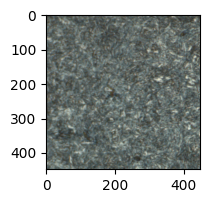

In [4]:
### 연결 리스트로 샘플 시리즈별 이미지 정리

def get_lined_img(img_size:int, step_size:int) -> dict:
  """
  이미지를 불러와서 샘플 시리즈를 keyword,
  이미지를 value로 갖는 딕셔너리를 반환함
  """

  # 빈 연결 리스트 생성
  imgs = {}
  for i in range(1,6):
    imgs[i] = []

  # 이미지를 크롭하여 시리즈별로 연결 리스트에 저장
  loc = "./images/"
  files = [f for f in os.listdir(loc) if "tif" in f]
  for file in files:
    img = (cv2.imread(loc + file)/255).astype(np.float32)
    h,w,c = img.shape
    for dx in range(0,h-img_size,step_size):
      for dy in range(0,w-img_size,step_size):
        img_crop = img[dx:dx+img_size,dy:dy+img_size]
        series = int(file[0])
        imgs[series].append(img_crop)

  return imgs

imgs = get_lined_img(img_size = 448, step_size = 56)

# check the result
print(imgs.keys())
plt.figure(figsize = (2,2))
plt.imshow(imgs[1][0]) # plot example

# 3. 이미지 별 물성 생성


In [5]:
def gen_properties(imgs:dict, properties:dict) -> np.array:
  """
  이미지가 해당 시리즈의 물성의 최대 최소 값 사이의 값을 가지도록
  물성 값을 랜덤하게 생성후 할당
  """
  # 빈 연결 리스트 생성
  gen_properties = {}
  for i in range(1,6):
    gen_properties[i] = []

  # 난수 시드 고정
  np.random.seed(0)

  # 생선된 물성 (gen_propertieserated) 연결 리스트에 저장
  for i in range(1,6):
      n_min = min(properties[i])
      n_max = max(properties[i])
      n_imgs = len(imgs[i])
      for _ in range(n_imgs):
        prop_gen = random.choice(range(n_min, n_max+1))
        gen_properties[i].append(prop_gen)

  return gen_properties

generated_properties = gen_properties(imgs, properties)
stacked_properties = np.concatenate(list(generated_properties.values()), dtype = np.float32) # dict to 1d array
stacked_properties_norm = (stacked_properties-min(stacked_properties))/ (max(stacked_properties)-min(stacked_properties))  # 최소값을 0, 최대값을 1로
print(f"len, min, max of stacked_properties: {len(stacked_properties_norm),min(stacked_properties_norm),max(stacked_properties_norm)}")

def stack_imgs(imgs:dict) -> np.array:
  """
  샘플별 이미지 딕셔너리를 1d array로 변환
  """
  n = sum([len(imgs[i]) for i in imgs])   # 이미지 총 갯수

  # 이미지 차원 구하기
  h,w,c = imgs[1][0].shape # 1번째 시리즈의 1번째 이미지
  # 빈 이미지 변수 생성 -> 미리 만들어주는게 효율적
  imgs_stack = np.empty((n,h,w,c), dtype = np.float32)

  # 이미지 쌓기
  idx = 0
  for i in imgs:
    for img in imgs[i]:
      imgs_stack[idx] = img
      idx += 1
  return imgs_stack

stacked_imgs = stack_imgs(imgs)

# check the input and output
X = stacked_imgs
y = stacked_properties_norm

print(f"type of X:{type(X)}, type of y:{type(y)}")
print(f"shape of X:{X.shape}, shape of y:{y.shape}")
print(f"dtype of X:{X.dtype}, dtype of y:{y.dtype}")

len, min, max of stacked_properties: (600, 0.0, 1.0)
type of X:<class 'numpy.ndarray'>, type of y:<class 'numpy.ndarray'>
shape of X:(600, 448, 448, 3), shape of y:(600,)
dtype of X:float32, dtype of y:float32


# 4. 데이터 전처리

In [6]:
# 훈련 데이터와 검증 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.9, random_state = 0)
print(f"shape of X_train:{X_train.shape}")
print(f"shape of X_test:{X_test.shape}")
print(f"shape of y_train:{y_train.shape}")
print(f"shape of y_test:{y_test.shape}")
print("-"*50)

# 이미지 데이터  변환
img_transformer = transforms.Compose([
        transforms.ToTensor(), # 텐서화
        transforms.Normalize(  # 정규화
            mean = [0.485, 0.456, 0.406],
            std = [0.229, 0.224, 0.225],
            ),
        ])

# 이미지 데이터 클래스 정의
class img_dataset(Dataset):
  def __init__(self,x,y,transform):
    self.x = x
    self.y = y
    self.T = transform

  def __len__(self):
    return len(self.x)

  def __getitem__(self, idx):
    return self.T(self.x[idx]), self.y[idx]

# 데이터로더에 훈련데이터 격납
train_dataset = img_dataset(X_train, y_train, img_transformer)
test_dataset = img_dataset(X_test, y_test, img_transformer)
train_loader = DataLoader(train_dataset, batch_size = 10, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 10, shuffle = True)

# 결과 확인
# tmp = list(iter(train_loader))
# print(f"shape of train batch imgs:{tmp[0][0].shape}")
# print(f"shape of train batch labels:{tmp[0][1].shape}")
# plt.figure(figsize = (4,4))
# plt.imshow(tmp[0][0][0].permute(1,2,0)) # 1st img of the batch

shape of X_train:(540, 448, 448, 3)
shape of X_test:(60, 448, 448, 3)
shape of y_train:(540,)
shape of y_test:(60,)
--------------------------------------------------


# 5. 모델링

In [7]:
# loading resnet101
my_model = models.resnet101(pretrained = True)

# change in and out features of fc layer
in_features = my_model.fc.in_features
out_features = 1
my_model.fc = nn.Linear(in_features, out_features)

# freeze parameters when training
for params in my_model.parameters():
  params.requires_grad = True

# unfreeze parameters of fc layer when training
for params in my_model.fc.parameters():
  params.requires_grad = True

# model to device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device={device}")
my_model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


device=cuda


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# 6. 모델 훈련

In [8]:
# # 파라미터 설정
# n_epoch = 20
# criterion = nn.MSELoss()
# optimizer = optim.Adam(my_model.parameters(), lr = 0.00001)

# train_loss_lst = []
# test_loss_lst = []

# for i in range(n_epoch):
#   for j,[x,y] in enumerate(train_loader):
#     x = x.to(device)
#     y = y.unsqueeze(1).to(device)

#     optimizer.zero_grad()
#     y_pred = my_model(x)
#     loss = criterion(y,y_pred)
#     loss.backward()
#     optimizer.step()

#     train_loss_lst.append(loss.item())


#     with torch.no_grad():
#       test_loss = 0
#       n = 0
#       for k, [x_test, y_test] in enumerate(test_loader):
#         x_test = x_test.to(device)
#         y_test = y_test.to(device)
#         y_test_pred = my_model(x_test)
#         loss_test = criterion(y_test, y_test_pred)
#         test_loss += loss_test.item()
#         n+=1
#     test_loss /= n
#     test_loss_lst.append(test_loss)

#     # 훈련 진행 상황 출력
#     print(f"i:{i}    j:{j}    train_loss:{loss.item():.4f}    test_loss:{test_loss:.3f}    y_test:{y_test[0].item():.3f}    y_test_pred:{y_test_pred[0].item():.3f}")

#     # 모델 저장
#     if i >= 1 and loss.item() == min(train_loss_lst):
#       print("train model saved")
#       torch.save(my_model.state_dict(), "train_best_model.pth")

#     if i >= 1  and test_loss == min(test_loss_lst):
#       print("val model saved")
#       torch.save(my_model.state_dict(), "test_best_model.pth")

#     torch.save(my_model.state_dict(), "last_model.pth")

# 7. 훈련 결과 플롯

In [9]:
def predict(model, dataloader:DataLoader, pretrained:str = None)-> list:
    """
    pretrained 모델 있으면 로드하여 예측을 진행, 없으면 모델 그대로 예측을 진행
    라벨(y) 및 예측 (y_pred)를 리스트로 반환
    """

    device = "cuda" if torch.cuda.is_available() else "cpu"
    if pretrained != None:
        model.load_state_dict(torch.load(pretrained, "cuda"))
    model = nn.DataParallel(model) # 멀티 GPU 사용
    model.to(device)

    y_lst = []
    y_pred_lst = []

    for i,j in dataloader:
        j = j.tolist()
        y_lst.extend(j)
        y_pred = model(i.to(device))
        y_pred = y_pred.squeeze(1).to("cpu").tolist() # GPU 메모리 절약 위해
        y_pred_lst.extend(y_pred)

    return y_lst, y_pred_lst

def denormalize(lst:list) -> list:
    """
    정규화된 물성 리스트를 받아 비정규화된 물성 리스트를 반환
    """
    n_min = min(stacked_properties)
    n_max = max(stacked_properties)

    res = []
    for i in lst:
        res.append((n_max-n_min)*i + n_min)
    return res

def get_rmse(x:list,y:list) -> float:
    """
    Root means square error (RMSE) 계산하여 반환
    """
    rmse = np.array(x)- np.array(y)
    rmse = np.square(rmse).sum()/len(x)
    rmse = np.power(rmse,0.5)
    return rmse

train_rsme:38.87699031078076
test_rsme:34.815800259527286


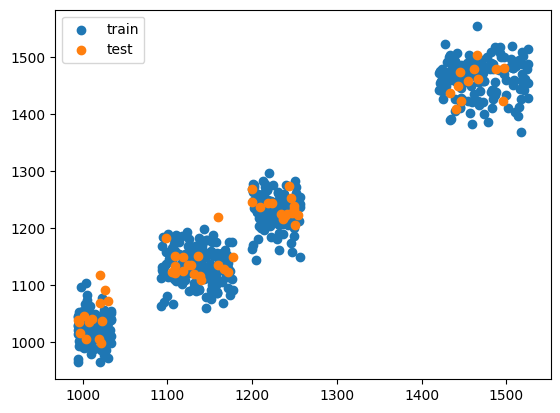

In [10]:
y_lst, y_pred_lst = predict(my_model.to(device), train_loader, "./models/test_best_model.pth")
y_lst = denormalize(y_lst)
y_pred_lst = denormalize(y_pred_lst)
plt.scatter(y_lst, y_pred_lst, label = "train")
print(f"train_rsme:{get_rmse(y_lst,y_pred_lst)}")

y_lst, y_pred_lst = predict(my_model.to(device), test_loader, "./models/test_best_model.pth")
y_lst = denormalize(y_lst)
y_pred_lst = denormalize(y_pred_lst)
plt.scatter(y_lst, y_pred_lst, label = "test")
print(f"test_rsme:{get_rmse(y_lst,y_pred_lst)}")

plt.legend()

#8. GradCAM 실행

In [11]:
my_model.load_state_dict(torch.load("./models/test_best_model.pth", "cuda"))
my_model.eval()

# final conv layer name
finalconv_name = 'layer4'

# activations
feature_blobs = []

# gradients
backward_feature = []

# output으로 나오는 feature를 feature_blobs에 append하도록
def hook_feature(module, input, output):
    feature_blobs.append(output.cpu().data.numpy())


# Grad-CAM
def backward_hook(module, input, output):
    backward_feature.append(output[0])


my_model._modules.get(finalconv_name).register_forward_hook(hook_feature)
my_model._modules.get(finalconv_name).register_backward_hook(backward_hook)


In [12]:
# get the softmax weight
params = list(my_model.parameters())
weight_softmax = np.squeeze(params[-2].cpu().detach().numpy())

In [13]:
X_cam, y_cam = next(iter(train_loader))
idx = torch.argmax(y_cam)
X_cam_idx = X_cam[idx]
y_cam_idx = y_cam[idx]
score = my_model(X_cam_idx.unsqueeze(0).to(device))
print(y_cam_idx, score)

tensor(0.9211) tensor([[1.0040]], device='cuda:0', grad_fn=<AddmmBackward0>)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [14]:
score.backward(retain_graph = True) # 예측값 y^c에 대해서 backprop 진행

In [15]:
activations = torch.Tensor(feature_blobs[0]).to(device) # (1, 512, 7, 7), forward activations
gradients = backward_feature[0] # (1, 512, 7, 7), backward gradients
b, k, u, v = gradients.size()

alpha = gradients.view(b, k, -1).mean(2) # (1, 512, 7*7) => (1, 512), feature map k의 'importance'
weights = alpha.view(b, k, 1, 1) # (1, 512, 1, 1)

grad_cam_map = (weights*activations).sum(1, keepdim = True) # alpha * A^k = (1, 512, 7, 7) => (1, 1, 7, 7)
grad_cam_map = F.relu(grad_cam_map) # Apply R e L U
grad_cam_map = F.interpolate(grad_cam_map, size=(448, 448), mode='bilinear', align_corners=False) # (1, 1, 224, 224)
map_min, map_max = grad_cam_map.min(), grad_cam_map.max()
grad_cam_map = (grad_cam_map - map_min).div(map_max - map_min).data # (1, 1, 224, 224), min-max scaling

# grad_cam_map.squeeze() : (224, 224)
grad_heatmap = cv2.applyColorMap(np.uint8(255 * grad_cam_map.squeeze().cpu()), cv2.COLORMAP_JET) # (224, 224, 3), numpy
grad_heatmap = torch.from_numpy(grad_heatmap).permute(2, 0, 1).float().div(255) # (3, 244, 244)
b, g, r = grad_heatmap.split(1)
grad_heatmap = torch.cat([r, g, b]) # (3, 244, 244), opencv's default format is BGR, so we need to change it as RGB format.

save_image(grad_heatmap, os.path.join("./", "Grad_CAM.jpg"))

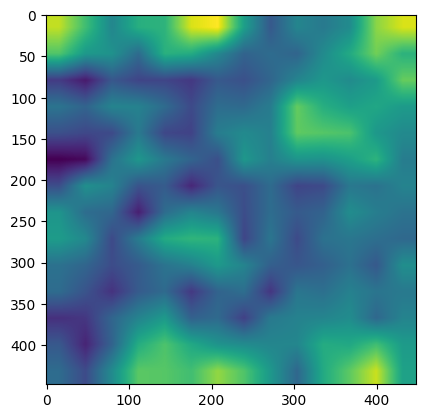

In [16]:
plt.imshow(grad_cam_map[0][0].to("cpu").detach())

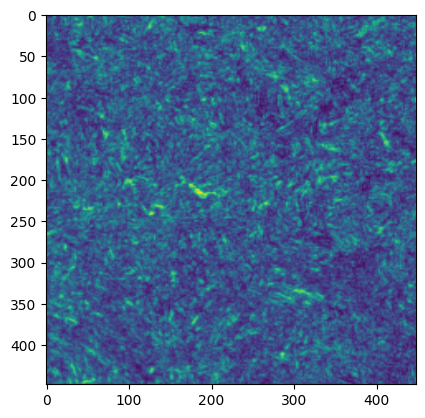

In [17]:
plt.imshow(X_cam_idx[0])